<a href="https://colab.research.google.com/github/soobook/PyTorch-DL/blob/main/code/PT05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5회차: DNN을 활용한 심장병 판별 (3) – 모델 구현과 평가

## 1. DNN 구현

In [39]:
# 라이브러리 가져 오기
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# 1. 지난 수업에서 만든 심장병 데이터셋 파일 불러오기
df = pd.read_csv("heart_disease_zscore.csv")

In [40]:
# 2. 특성과 타겟 분리
X = df.drop(columns=["target"]).astype(np.float32)
y = df["target"].astype(np.float32)

In [41]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        303 non-null    float32
 1   sex        303 non-null    float32
 2   trestbps   303 non-null    float32
 3   chol       303 non-null    float32
 4   fbs        303 non-null    float32
 5   thalach    303 non-null    float32
 6   exang      303 non-null    float32
 7   oldpeak    303 non-null    float32
 8   ca         303 non-null    float32
 9   cp_1       303 non-null    float32
 10  cp_2       303 non-null    float32
 11  cp_3       303 non-null    float32
 12  cp_4       303 non-null    float32
 13  restecg_0  303 non-null    float32
 14  restecg_1  303 non-null    float32
 15  restecg_2  303 non-null    float32
 16  slope_1    303 non-null    float32
 17  slope_2    303 non-null    float32
 18  slope_3    303 non-null    float32
 19  thal_3.0   303 non-null    float32
 20  thal_6.0  

In [42]:
X.sample(3)

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,cp_1,...,cp_4,restecg_0,restecg_1,restecg_2,slope_1,slope_2,slope_3,thal_3.0,thal_6.0,thal_7.0
115,-1.489288,1.0,0.188395,-0.845268,0.0,-0.770990,0.0,-0.896862,-0.723095,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
73,1.170364,1.0,-1.234430,0.025283,0.0,0.367503,0.0,-0.379244,1.428203,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
90,1.281183,1.0,-0.665300,1.069944,0.0,0.060985,0.0,-0.551784,-0.723095,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [43]:
# 3. 훈련/테스트 분할
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.2, random_state=42, stratify=y
)

In [44]:
X_train[:2]

array([[-0.7135564 ,  1.        , -0.43764773,  0.5282683 ,  0.        ,
         0.7178079 ,  0.        , -0.46551394, -0.723095  ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  1.        ],
       [ 0.0621756 ,  1.        , -0.09616981,  0.2961214 ,  0.        ,
         0.23613812,  0.        , -0.89686173, -0.723095  ,  0.        ,
         1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ]], dtype=float32)

In [45]:
# 4. Dataset 클래스 정의
from torch.utils.data import Dataset, DataLoader

# PyTorch의 Dataset 클래스를 상속받아 사용자 정의 데이터셋을 정의함
class HeartDataset(Dataset):
    # 생성자: 입력 데이터(X)와 레이블(y)을 텐서 형태로 변환함
    def __init__(self, X, y):
        # X 데이터를 float32 타입의 텐서로 변환
        self.X = torch.tensor(X, dtype=torch.float32)
        # y 데이터를 float32 타입으로 변환하고 (N, 1) 형태로 reshape
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    # 데이터셋의 전체 길이(샘플 수)를 반환
    def __len__(self):
        return len(self.y)

    # 주어진 인덱스(idx)에 해당하는 데이터(X, y) 쌍을 반환
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 학습용 데이터셋 객체 생성 (훈련 데이터로부터 HeartDataset 구성)
train_dataset = HeartDataset(X_train, y_train)
# 테스트용 데이터셋 객체 생성 (테스트 데이터로부터 HeartDataset 구성)
test_dataset = HeartDataset(X_test, y_test)

# 학습 데이터로더 생성 (배치 크기 32, 매 epoch마다 데이터 순서 섞기)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# 테스트 데이터로더 생성 (배치 크기 32, 데이터 순서 고정)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [46]:
# train_loader: 배치 단위로 데이터를 공급하는 반복 가능한 DataLoader 객체
for feature, label in train_loader:
    print(feature.shape)
    print(label.shape)
    break

torch.Size([32, 22])
torch.Size([32, 1])


In [47]:
# 5. 모델 정의
class DNN(nn.Module):
    def __init__(self, input_dim):
        super(DNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)  # Sigmoid 제거
        )

    def forward(self, x):
        return self.net(x)

model = DNN(input_dim=X.shape[1])

In [48]:
# 입력층의 뉴런 수
X_train.shape[1]

22

## 2. DNN 학습

In [49]:
# 6. 손실함수와 옵티마이저
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [50]:
# 7. 학습 루프
# 학습 반복 횟수를 50으로 설정
epochs = 50

# 지정된 epoch 수만큼 학습을 반복
for epoch in range(epochs):
    # 모델을 학습 모드로 전환 (Dropout, BatchNorm 활성화)
    model.train()
    # 한 에폭 동안의 누적 손실값 초기화
    running_loss = 0

    # 배치 단위로 학습 데이터를 불러와 학습 수행
    for X_batch, y_batch in train_loader:
        # 이전 단계의 기울기(gradient) 초기화
        optimizer.zero_grad()
        # 모델 예측값 계산
        outputs = model(X_batch)
        # 손실 함수로 실제값과 예측값의 차이 계산
        loss = criterion(outputs, y_batch)
        # 역전파(backpropagation) 수행하여 기울기 계산
        loss.backward()
        # 옵티마이저로 파라미터 업데이트
        optimizer.step()
        # 손실값을 누적하여 평균 계산에 사용
        running_loss += loss.item()

    # 스케줄러를 통해 학습률 조정
    scheduler.step()
    # 한 epoch의 평균 손실값 계산
    avg_loss = running_loss / len(train_loader)

    # 10 epoch마다 현재 학습 상태 출력
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:2d} | Loss: {avg_loss:.4f}")

Epoch 10 | Loss: 0.5903
Epoch 20 | Loss: 0.4531
Epoch 30 | Loss: 0.3933
Epoch 40 | Loss: 0.3656
Epoch 50 | Loss: 0.3335


## 3. DNN 평가

In [51]:
# 8. 평가
# 모델을 평가 모드로 전환 (Dropout, BatchNorm 비활성화)
model.eval()

# 예측값과 실제값을 저장할 리스트 초기화
y_pred = []
y_true = []

# 평가 시에는 기울기 계산을 비활성화하여 메모리 사용량 절감 및 속도 향상
with torch.no_grad():
    # 테스트 데이터로더에서 배치 단위로 데이터 불러오기
    for X_batch, y_batch in test_loader:
        # 모델을 통해 예측값 계산
        outputs = model(X_batch)
        # 출력값에 시그모이드 함수를 적용하여 확률값으로 변환
        probs = torch.sigmoid(outputs)
        # 0.5를 기준으로 이진 분류 결과(0 또는 1)로 변환
        preds = (probs > 0.5).float()
        # 예측값을 리스트에 추가 (CPU로 이동 후 NumPy 배열로 변환)
        y_pred.extend(preds.cpu().numpy())
        # 실제값을 리스트에 추가 (CPU로 이동 후 NumPy 배열로 변환)
        y_true.extend(y_batch.cpu().numpy())

In [52]:
# 9. 결과 출력
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("=== Evaluation Metrics ===")
print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
print(f"Recall   : {recall_score(y_true, y_pred, zero_division=0):.4f}")
print(f"F1 Score : {f1_score(y_true, y_pred, zero_division=0):.4f}")

=== Evaluation Metrics ===
Accuracy : 0.8689
Precision: 0.8125
Recall   : 0.9286
F1 Score : 0.8667


### 혼돈 행렬 시각화

In [53]:
%config InlineBackend.figure_format = 'retina'

In [54]:
import matplotlib.pyplot as plt

# 한번 설정하면 그림 크기 설정이 계속 반영
plt.rcParams.update({'figure.figsize': (4, 3)})

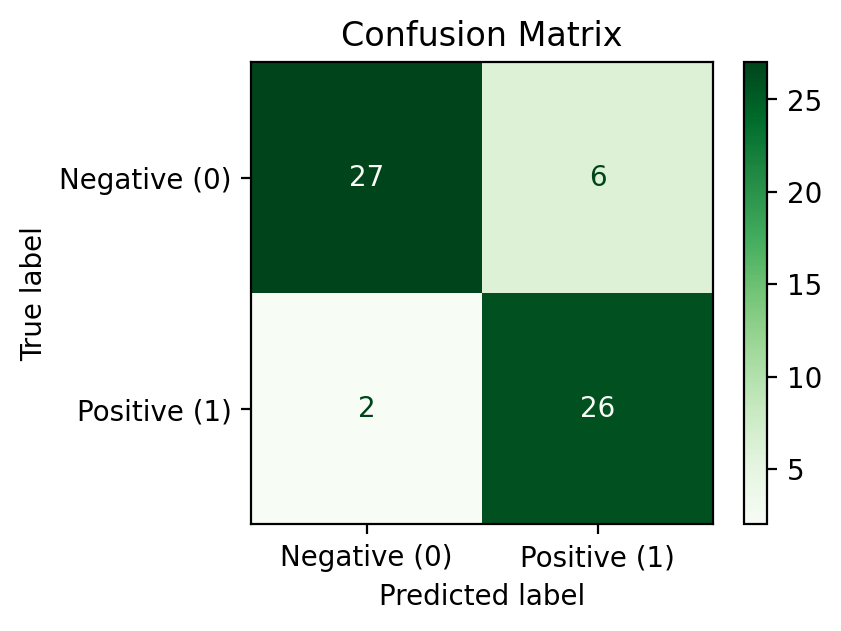

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative (0)", "Positive (1)"])
disp.plot(cmap="Greens")
plt.title("Confusion Matrix")
plt.show()

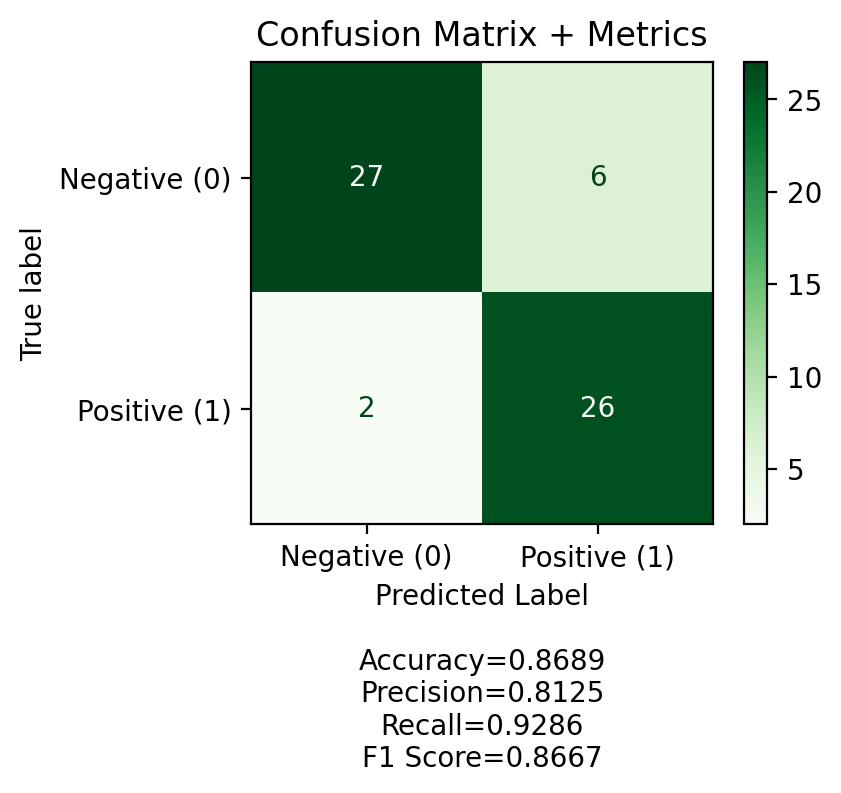

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# 혼돈 행렬 계산 및 시각화
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative (0)", "Positive (1)"])
disp.plot(cmap="Greens")

# 주요 평가 지표 계산
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

# 지표 값을 그림 안에 텍스트로 출력
plt.title("Confusion Matrix + Metrics")
plt.xlabel(f"Predicted Label\n\nAccuracy={acc:.4f}\nPrecision={prec:.4f}\nRecall={rec:.4f}\nF1 Score={f1:.4f}")
plt.show()

### 혼동 행렬에 직접 값을 쓰기
- np.ndenumerate(cm) → 2차원 배열 cm의 각 원소의 좌표(i, j)와 값(val)을 순회

| 위치    | 의미 | 값       |
| ----- | -- | ------- |
| (0,0) | TN | cm[0,0] |
| (0,1) | FP | cm[0,1] |
| (1,0) | FN | cm[1,0] |
| (1,1) | TP | cm[1,1] |


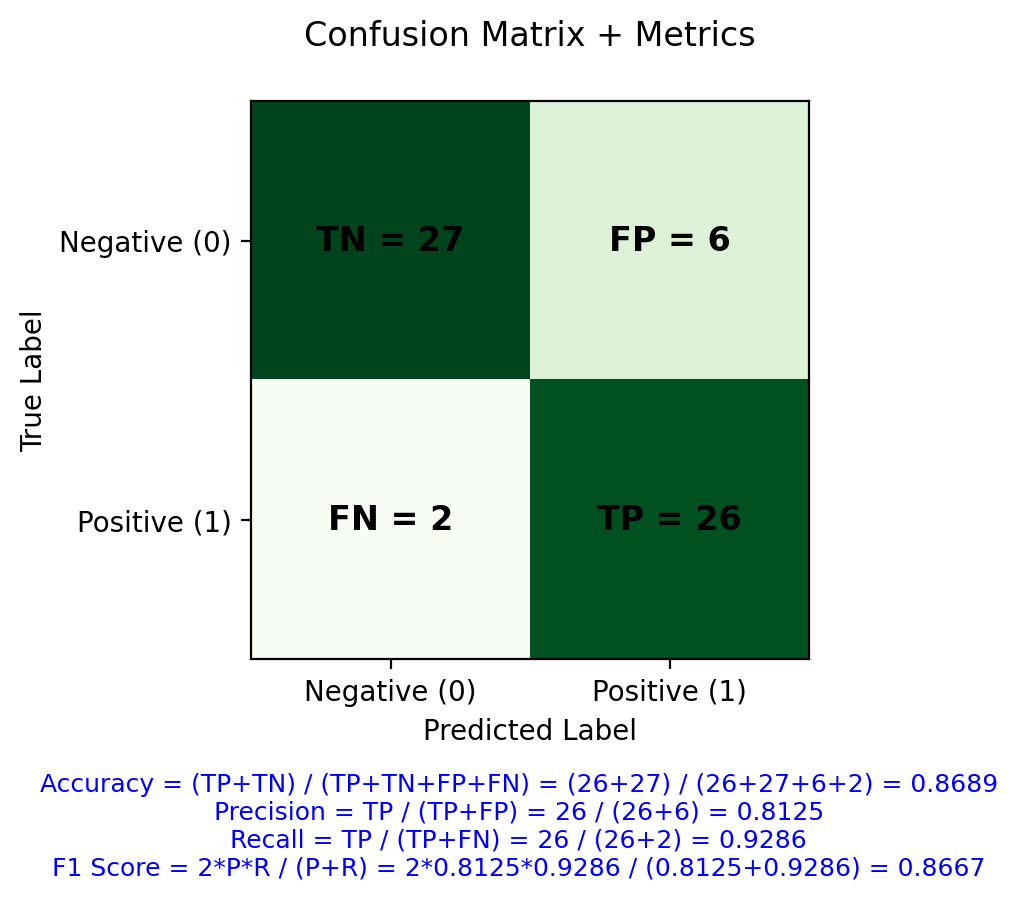

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 혼돈 행렬 계산
cm = confusion_matrix(y_true, y_pred)
TN, FP, FN, TP = cm.ravel() # 행렬의 4개의 값을 저장

# 평가 지표 계산
acc = (TP + TN) / (TP + TN + FP + FN)
prec = TP / (TP + FP) if (TP + FP) > 0 else 0
rec  = TP / (TP + FN) if (TP + FN) > 0 else 0
f1   = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0

# 시각화
fig, ax = plt.subplots(figsize=(4.5, 4.5))
ax.matshow(cm, cmap="Greens")

# 제목
ax.set_title("Confusion Matrix + Metrics", pad=20)
# === 축/라벨을 '그린 뒤'에 다시 지정 ===
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Negative (0)", "Positive (1)"], fontsize=10)
ax.set_yticklabels(["Negative (0)", "Positive (1)"], fontsize=10)

# x라벨을 아래로 강제하고, 위쪽 라벨은 끈다
ax.xaxis.set_ticks_position('bottom')   # = ax.xaxis.tick_bottom()
ax.tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)
# ax.tick_params(axis='x', bottom=True, top=True, labelbottom=True, labeltop=True)
ax.tick_params(axis='y', left=True, right=False, labelleft=True)

# 축 경계(클리핑 방지용)
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(1.5, -0.5)  # (imshow 기본은 위->아래. 원하는 방향이면 유지/삭제)

# 축 제목
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

# 셀 내부에 TP, TN, FP, FN 텍스트 쓰기
for (i, j), val in np.ndenumerate(cm):
    if   (i, j) == (1, 1): label = f"TP = {val}"
    elif (i, j) == (0, 0): label = f"TN = {val}"
    elif (i, j) == (0, 1): label = f"FP = {val}"
    else:                  label = f"FN = {val}"  # (1, 0)
    # 행렬의 (i, j) → 시각화 좌표 (x=j, y=i)이므로 (j, i) 순으로 텍스트 위치 지정
    ax.text(j, i, label, va='center', ha='center', fontsize=12, fontweight='bold', color='black')

# 수식 및 결과 문자열
metrics_text = (
    f"Accuracy = (TP+TN) / (TP+TN+FP+FN) = ({TP}+{TN}) / ({TP}+{TN}+{FP}+{FN}) = {acc:.4f}\n"
    f"Precision = TP / (TP+FP) = {TP} / ({TP}+{FP}) = {prec:.4f}\n"
    f"Recall = TP / (TP+FN) = {TP} / ({TP}+{FN}) = {rec:.4f}\n"
    f"F1 Score = 2*P*R / (P+R) = 2*{prec:.4f}*{rec:.4f} / ({prec:.4f}+{rec:.4f}) = {f1:.4f}"
)

# 아래쪽 공간을 넉넉히 확보하고 텍스트 배치
plt.subplots_adjust(bottom=0.26)  # 또는: plt.tight_layout(rect=[0, 0.18, 1, 1])
fig.text(0.5, 0.02, metrics_text, fontsize=9, color='blue', ha='center')
plt.show()


## 종료